In [1]:
import sys
sys.path.append('..')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import torch  # PyTorch의 경우
torch.set_grad_enabled(False)
print(torch.cuda.device_count())  # GPU 개수 확인
print(torch.cuda.current_device())  # 현재 활성화된 GPU 확인

from transformers import AutoModelForCausalLM, AutoTokenizer

1
0


/home/kdkyum/.miniconda3/envs/engram/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "meta-llama/Llama-2-13b-hf"
model_pretrain = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    use_cache=False,
)

local_model_path = "/home/kdkyum/workdir/llm_engram/model-output/Llama-2-13b-hf-bioS_multi5_permutes-lr5.0e-5/best_model"

model_finetune = AutoModelForCausalLM.from_pretrained(
    local_model_path,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    use_cache=False,
)

model_pretrain.eval()
model_finetune.eval()

Loading checkpoint shards:   0%|          | 0/3 [00:26<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gc

# Force garbage collection to free memory
gc.collect()
torch.cuda.empty_cache()

# Use sampling approach to estimate threshold
sample_size = 50000  # Smaller sample size to reduce memory
samples = []
sampled_elements = 0

# Get only relevant keys (from layers with mlp or attn)
relevant_keys = [k for k in model_finetune.state_dict().keys() 
                if k in model_pretrain.state_dict() and 
                "model.layers." in k and ("mlp" in k or "attn" in k)]

# Randomly sample differences for threshold estimation
import random
random.shuffle(relevant_keys)

for key in relevant_keys:
    if sampled_elements >= sample_size:
        break
        
    # Process on CPU to save GPU memory
    param_finetune = model_finetune.state_dict()[key].cpu()
    param_pretrain = model_pretrain.state_dict()[key].cpu()
    
    diff = torch.abs(param_finetune - param_pretrain).flatten()
    
    # Take only what we need for the sample
    num_to_sample = min(diff.numel(), sample_size - sampled_elements)
    if num_to_sample < diff.numel():
        indices = torch.randperm(diff.numel())[:num_to_sample]
        samples.append(diff[indices])
    else:
        samples.append(diff)
    
    sampled_elements += num_to_sample
    
    # Free memory
    del param_finetune, param_pretrain, diff
    gc.collect()

Estimated threshold for top 1% changes: 0.00011444091796875


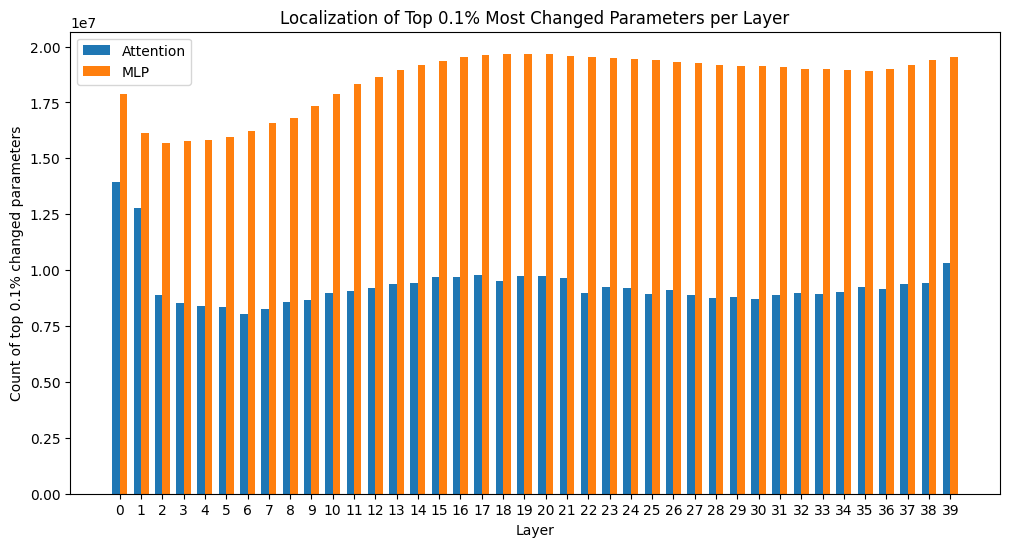

Estimated threshold for top 1% changes: 0.000213623046875


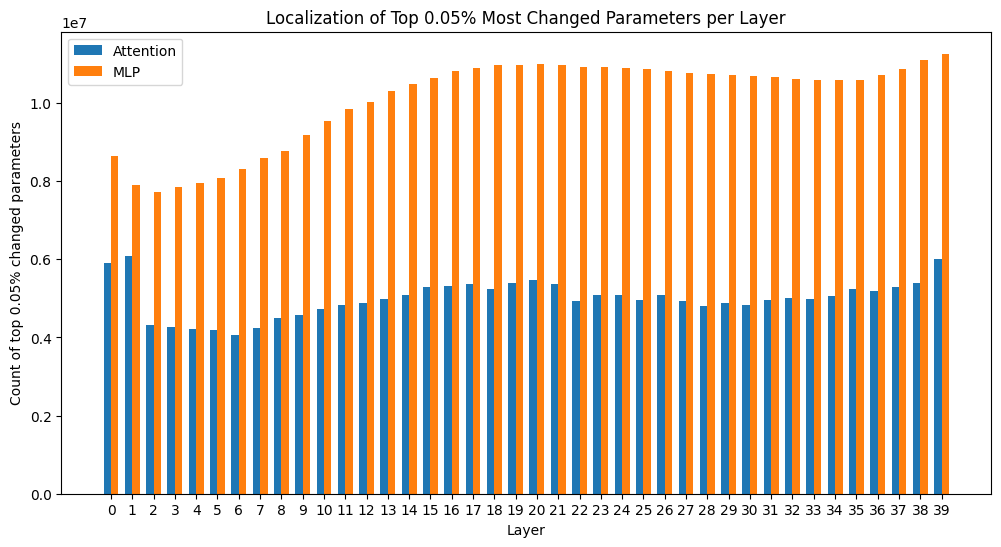

Estimated threshold for top 1% changes: 0.00040435791015625


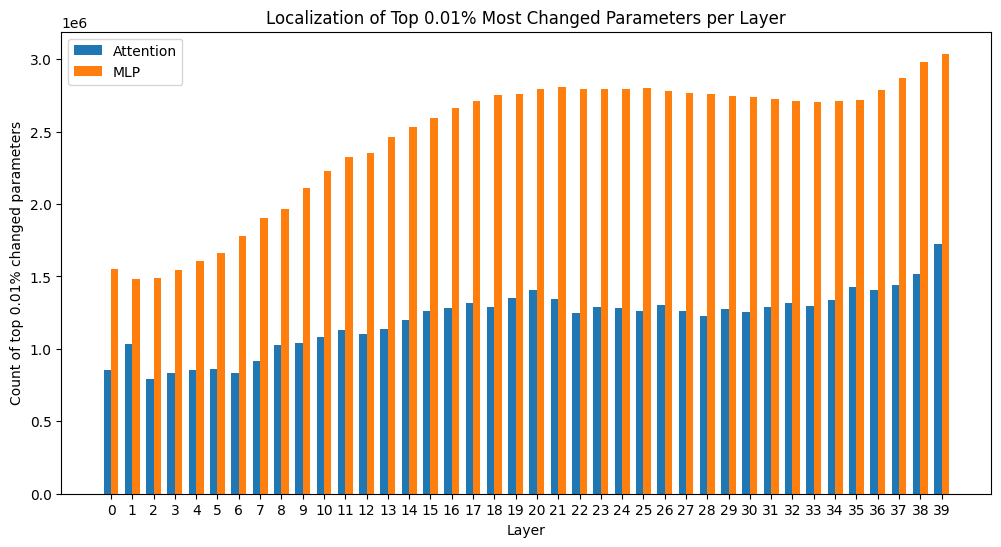

Estimated threshold for top 1% changes: 0.0006256103515625


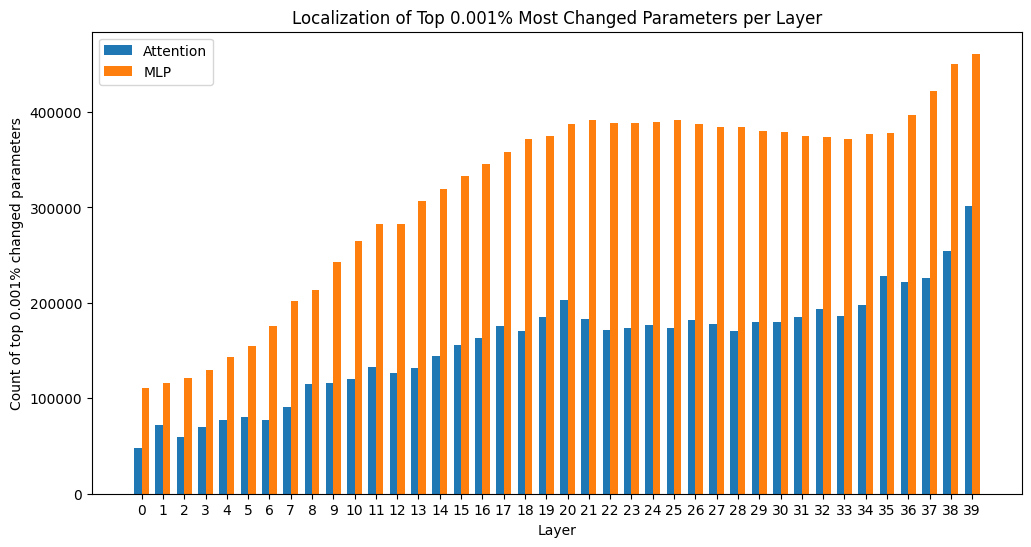

Estimated threshold for top 1% changes: 0.000823974609375


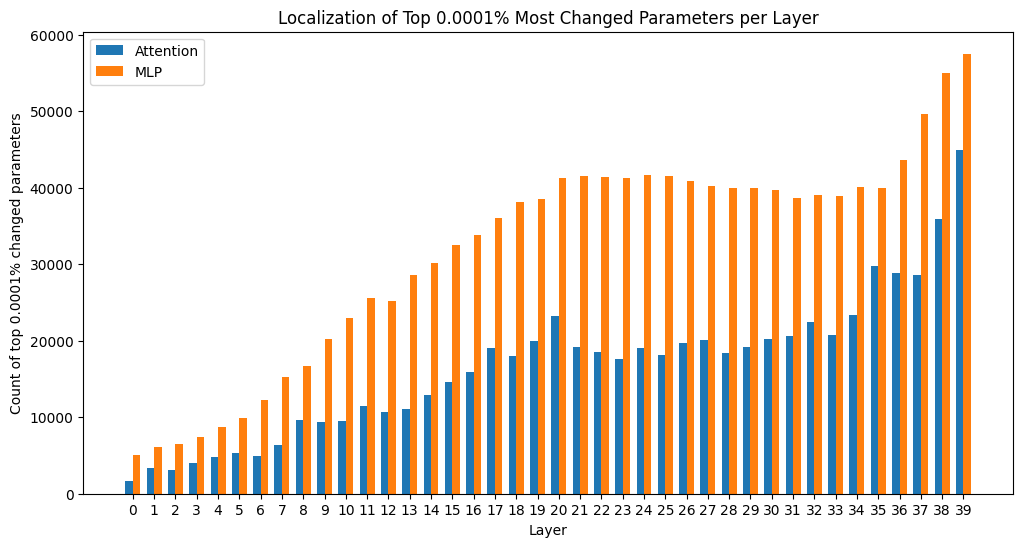

Estimated threshold for top 1% changes: 0.0008678436279296875


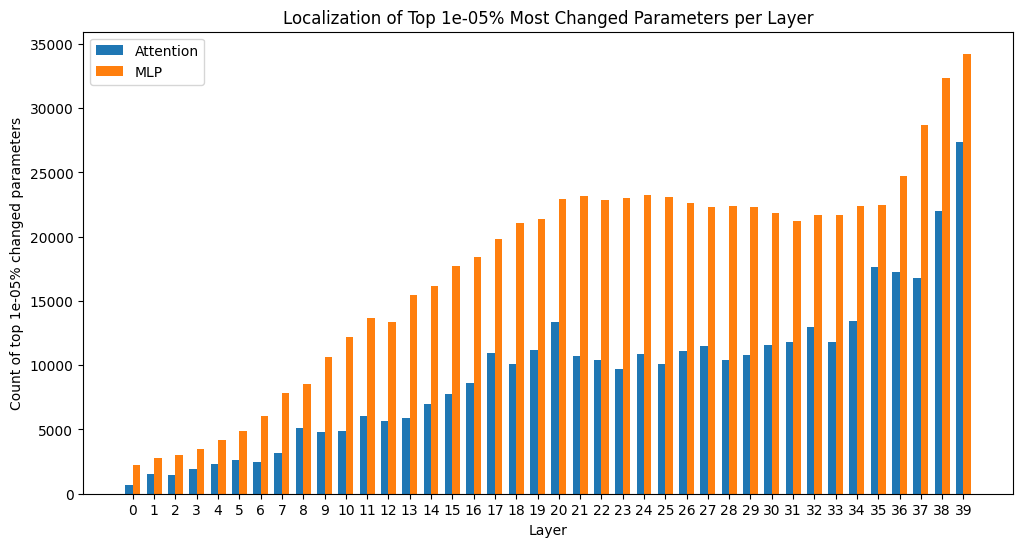

In [5]:

samples = torch.cat(samples).float()
for k in [0.1, 0.05, 0.01, 1e-3, 1e-4, 1e-5]:
    threshold = torch.quantile(samples, 1 - k).item()
    print(f"Estimated threshold for top 1% changes: {threshold}")

    # Count parameters above threshold per layer
    layer_changes = {}

    for key in relevant_keys:
        parts = key.split(".")
        layer_id = parts[2]
        
        if layer_id not in layer_changes:
            layer_changes[layer_id] = {"attn": 0, "mlp": 0}
        
        # Process on CPU
        param_finetune = model_finetune.state_dict()[key].cpu()
        param_pretrain = model_pretrain.state_dict()[key].cpu()
        
        # Count differences exceeding threshold
        count = (torch.abs(param_finetune - param_pretrain) >= threshold).sum().item()
        
        # Update counts
        if "mlp" in key:
            layer_changes[layer_id]["mlp"] += count
        elif "attn" in key:
            layer_changes[layer_id]["attn"] += count
        
        # Free memory
        del param_finetune, param_pretrain
        gc.collect()

    # Plot results
    layers = sorted(layer_changes.keys(), key=lambda x: int(x))
    attn_counts = [layer_changes[layer]["attn"] for layer in layers]
    mlp_counts = [layer_changes[layer]["mlp"] for layer in layers]

    x = np.arange(len(layers))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, attn_counts, width, label='Attention')
    ax.bar(x + width/2, mlp_counts, width, label='MLP')

    ax.set_xlabel('Layer')
    ax.set_ylabel(f'Count of top {k}% changed parameters')
    ax.set_title(f'Localization of Top {k}% Most Changed Parameters per Layer')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.legend()

    plt.show()

Estimated threshold for top 1% changes: 0.00086955726146698


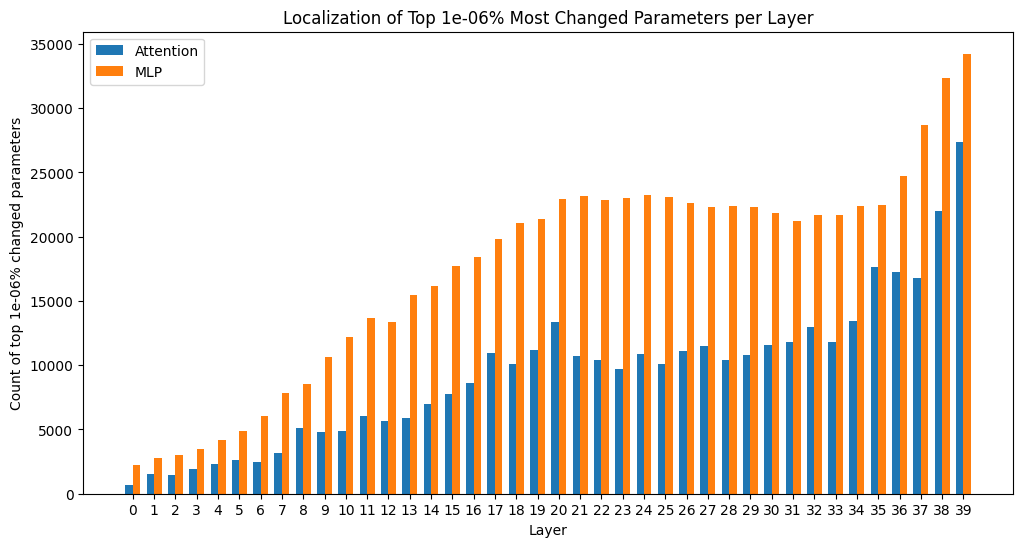

Estimated threshold for top 1% changes: 0.0008697211742401123


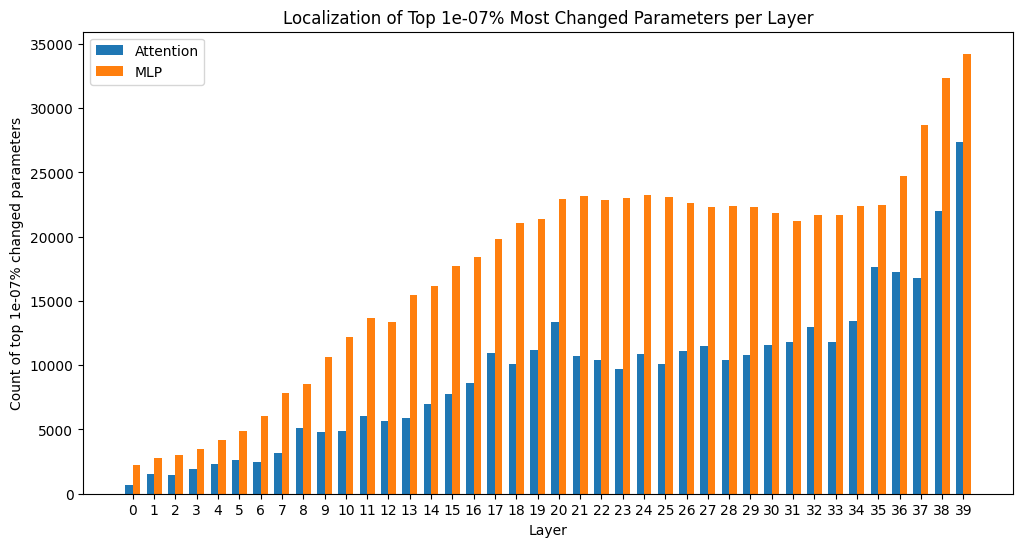

Estimated threshold for top 1% changes: 0.0008697509765625


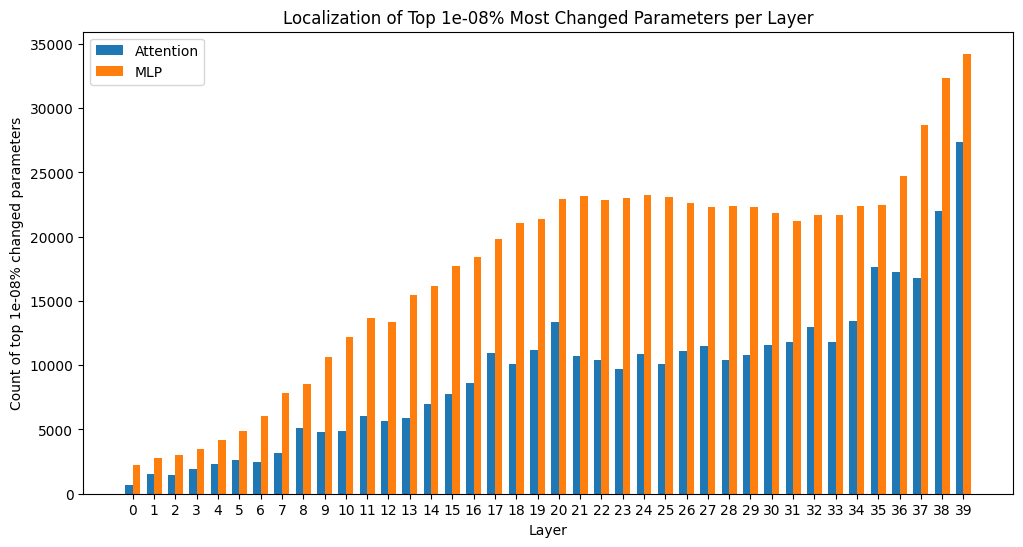

Estimated threshold for top 1% changes: 0.0008697509765625


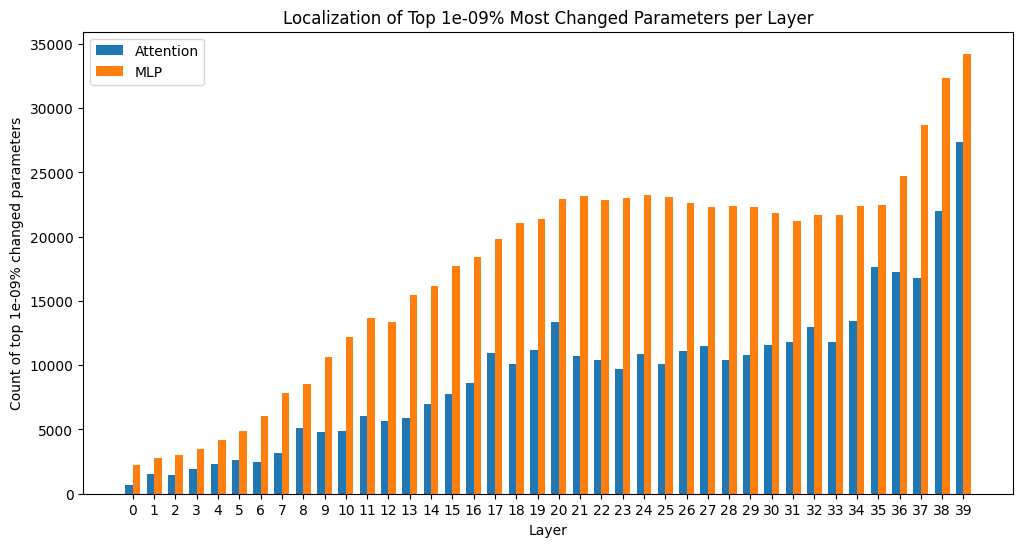

In [6]:

for k in [1e-6, 1e-7, 1e-8, 1e-9]:
    threshold = torch.quantile(samples, 1 - k).item()
    print(f"Estimated threshold for top 1% changes: {threshold}")

    # Count parameters above threshold per layer
    layer_changes = {}

    for key in relevant_keys:
        parts = key.split(".")
        layer_id = parts[2]
        
        if layer_id not in layer_changes:
            layer_changes[layer_id] = {"attn": 0, "mlp": 0}
        
        # Process on CPU
        param_finetune = model_finetune.state_dict()[key].cpu()
        param_pretrain = model_pretrain.state_dict()[key].cpu()
        
        # Count differences exceeding threshold
        count = (torch.abs(param_finetune - param_pretrain) >= threshold).sum().item()
        
        # Update counts
        if "mlp" in key:
            layer_changes[layer_id]["mlp"] += count
        elif "attn" in key:
            layer_changes[layer_id]["attn"] += count
        
        # Free memory
        del param_finetune, param_pretrain
        gc.collect()

    # Plot results
    layers = sorted(layer_changes.keys(), key=lambda x: int(x))
    attn_counts = [layer_changes[layer]["attn"] for layer in layers]
    mlp_counts = [layer_changes[layer]["mlp"] for layer in layers]

    x = np.arange(len(layers))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, attn_counts, width, label='Attention')
    ax.bar(x + width/2, mlp_counts, width, label='MLP')

    ax.set_xlabel('Layer')
    ax.set_ylabel(f'Count of top {k}% changed parameters')
    ax.set_title(f'Localization of Top {k}% Most Changed Parameters per Layer')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.legend()

    plt.show()

In [20]:
thresholdthreshold = torch.quantile(samples, 1 - 1e-10).item()

threshold = torch.quantile(samples, 0.9999999999999999999999999999).item()
print(f"Estimated threshold for top 1% changes: {threshold}")

Estimated threshold for top 1% changes: 0.0008697509765625


In [14]:
thresholdthreshold

0.0008697509765625

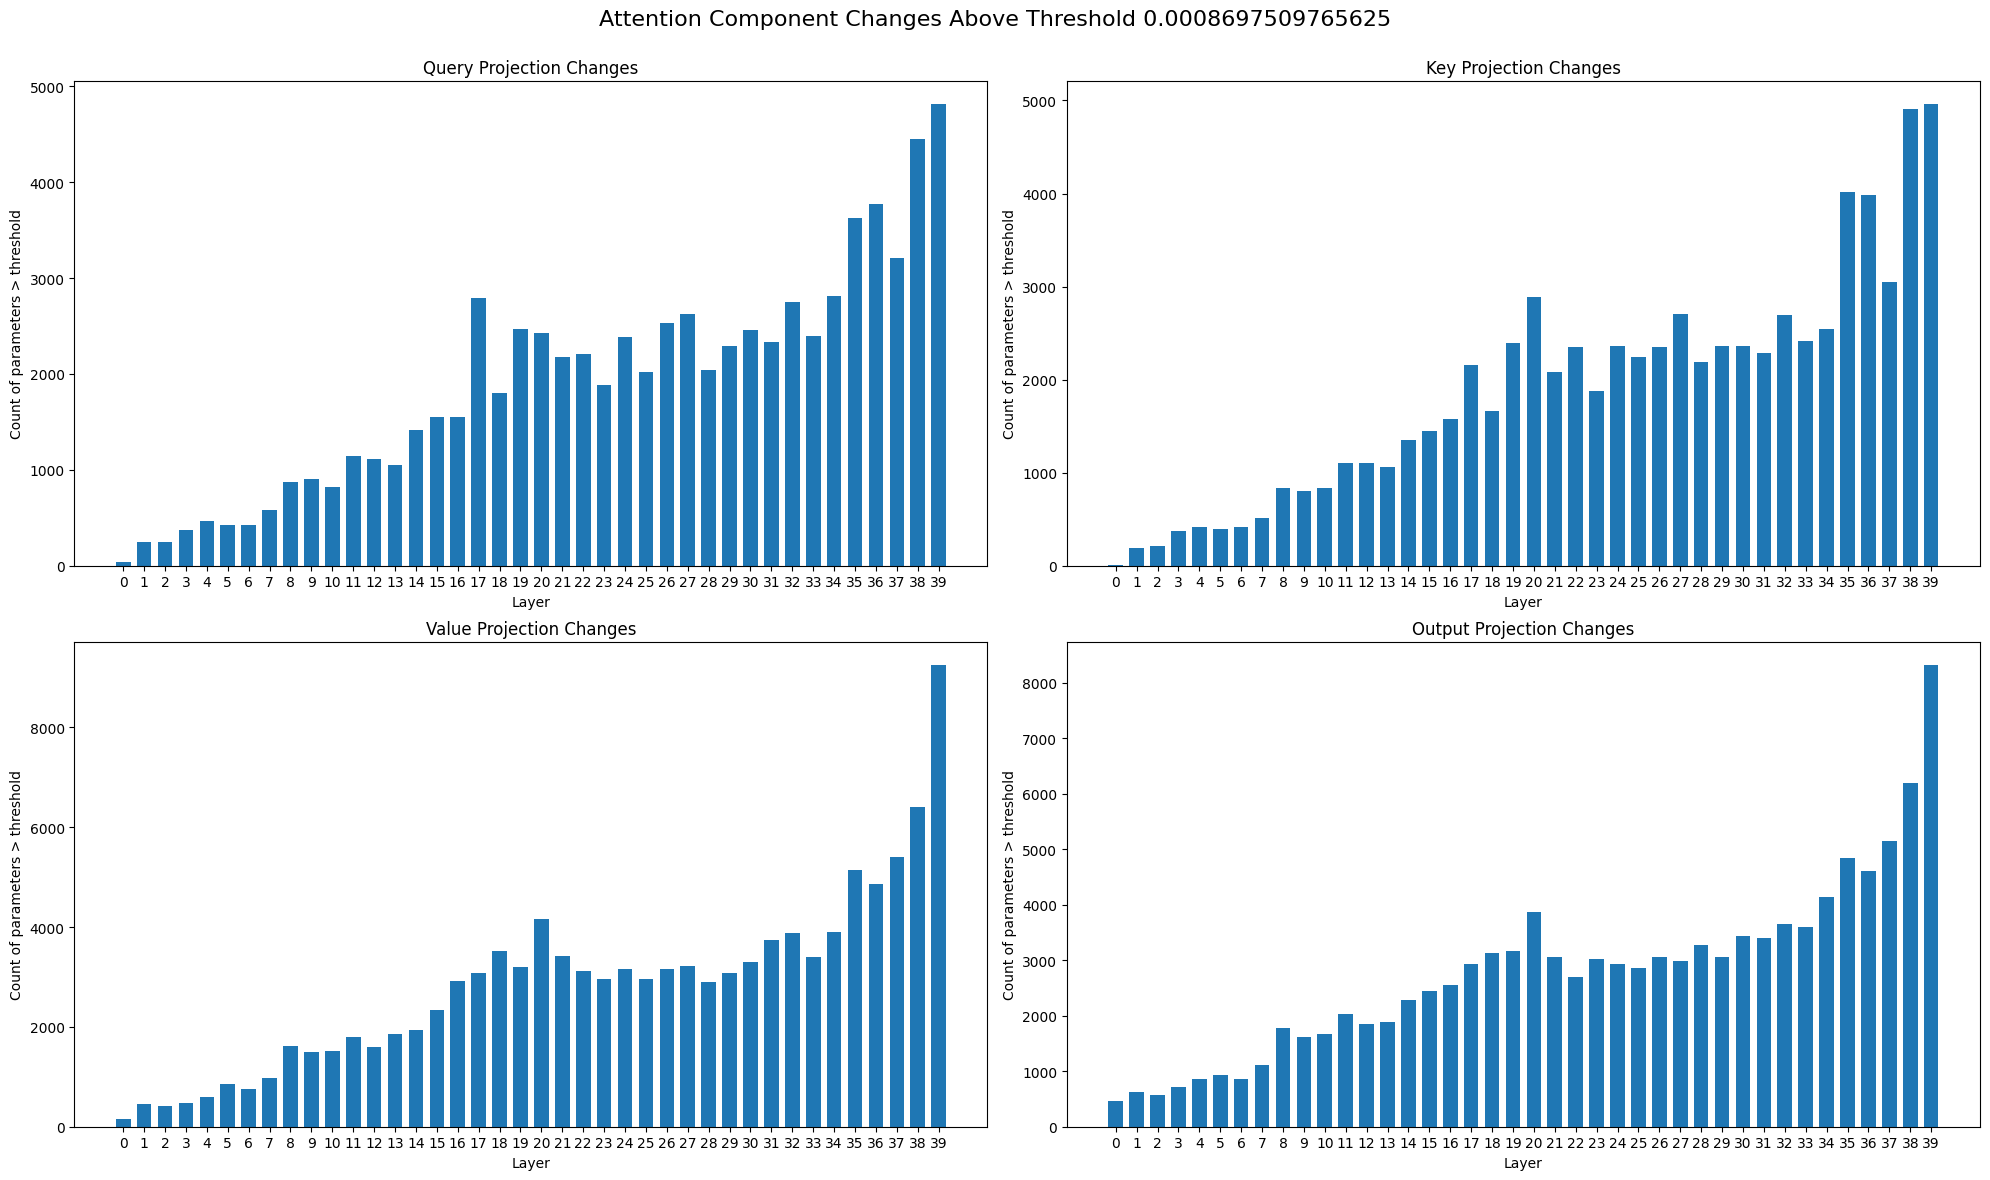

In [ ]:
# Set threshold
threshold = 0.0008697509765625

# Initialize dictionaries to track changes by component
layer_changes = {
    'q_proj': {layer: 0 for layer in range(40)},
    'k_proj': {layer: 0 for layer in range(40)},
    'v_proj': {layer: 0 for layer in range(40)},
    'o_proj': {layer: 0 for layer in range(40)}
}

# Process all attention keys
for key in relevant_keys:
    if "self_attn" not in key:
        continue
        
    parts = key.split(".")
    layer_id = int(parts[2])
    component = parts[4]  # Will be q_proj, k_proj, v_proj, or o_proj
    
    # Skip if not one of our target components
    if component not in layer_changes:
        continue
    
    # Process on CPU
    param_finetune = model_finetune.state_dict()[key].cpu()
    param_pretrain = model_pretrain.state_dict()[key].cpu()
    
    # Count differences exceeding threshold
    count = (torch.abs(param_finetune - param_pretrain) >= threshold).sum().item()
    layer_changes[component][layer_id] += count
    
    # Free memory
    del param_finetune, param_pretrain
    gc.collect()

# Create plot
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()

layers = list(range(40))
x = np.arange(len(layers))

# Plot each component
titles = ['Query Projection', 'Key Projection', 'Value Projection', 'Output Projection']
components = ['q_proj', 'k_proj', 'v_proj', 'o_proj']

for i, (component, title) in enumerate(zip(components, titles)):
    counts = [layer_changes[component][layer] for layer in layers]
    axs[i].bar(x, counts, width=0.7)
    axs[i].set_xlabel('Layer')
    axs[i].set_ylabel('Count of parameters > threshold')
    axs[i].set_title(f'{title} Changes')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(layers)

plt.tight_layout()
plt.suptitle(f'Attention Component Changes Above Threshold {threshold}', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()

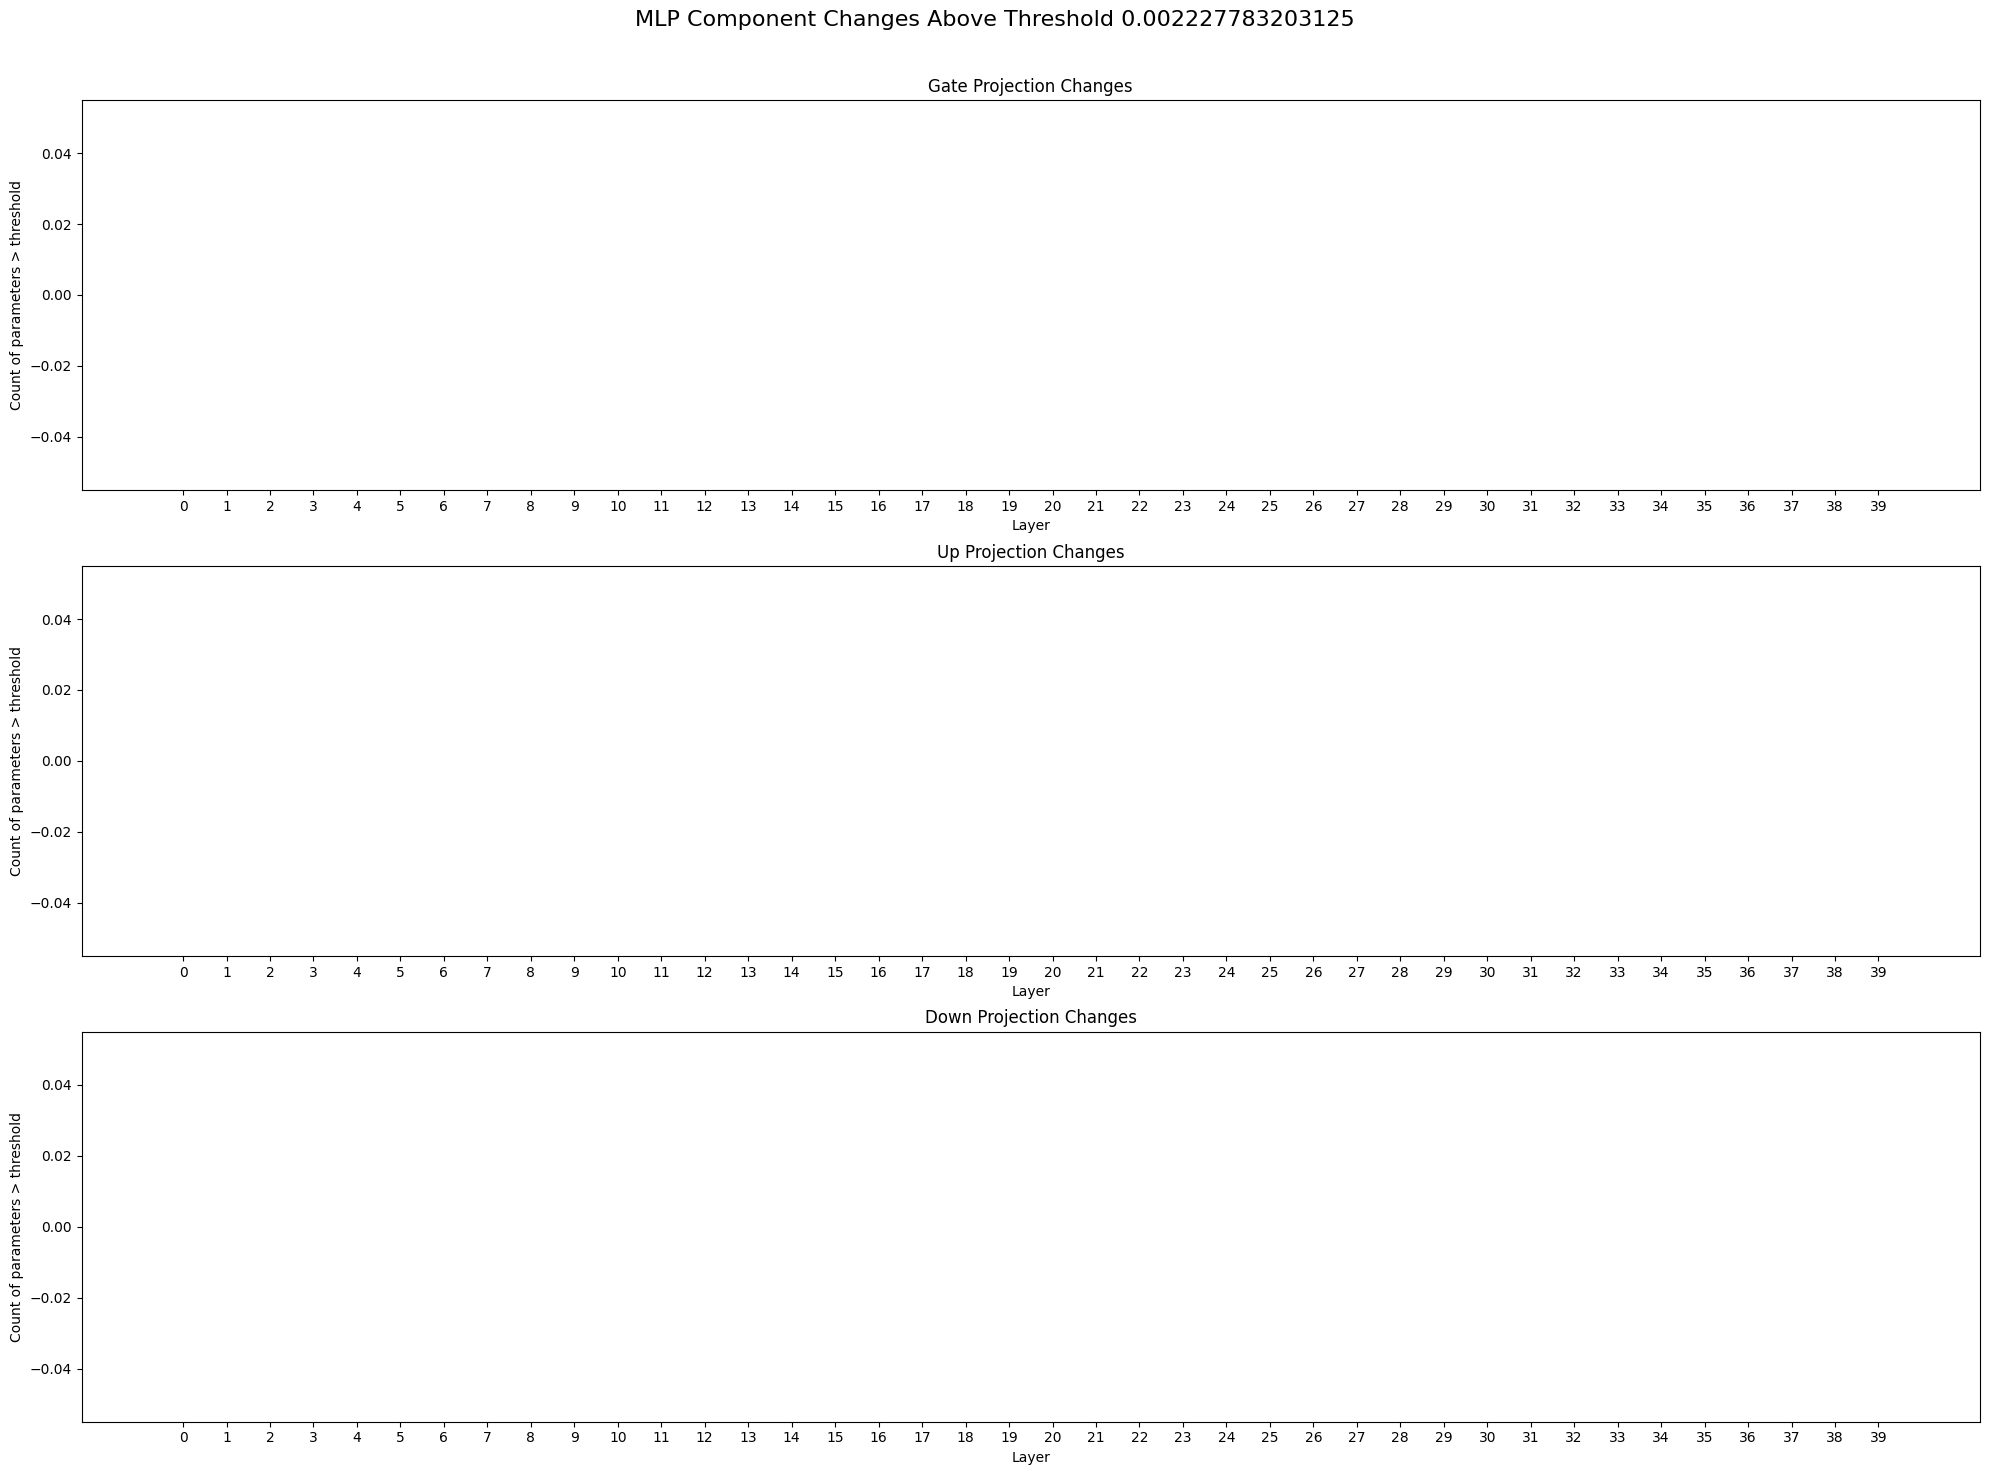

In [8]:
# Set threshold (using the same threshold from the previous cell)
threshold = 0.002227783203125

# Initialize dictionaries to track changes by component
mlp_changes = {
    'gate_proj': {layer: 0 for layer in range(40)},
    'up_proj': {layer: 0 for layer in range(40)},
    'down_proj': {layer: 0 for layer in range(40)}
}

# Process all MLP keys
for key in relevant_keys:
    if "mlp" not in key:
        continue
        
    parts = key.split(".")
    layer_id = int(parts[2])
    component = parts[4]  # Will be gate_proj, up_proj, or down_proj
    
    # Skip if not one of our target components
    if component not in mlp_changes:
        continue
    
    # Process on CPU
    param_finetune = model_finetune.state_dict()[key].cpu()
    param_pretrain = model_pretrain.state_dict()[key].cpu()
    
    # Count differences exceeding threshold
    count = (torch.abs(param_finetune - param_pretrain) >= threshold).sum().item()
    mlp_changes[component][layer_id] += count
    
    # Free memory
    del param_finetune, param_pretrain
    gc.collect()

# Create plot
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
axs = axs.flatten()

layers = list(range(40))
x = np.arange(len(layers))

# Plot each component
titles = ['Gate Projection', 'Up Projection', 'Down Projection']
components = ['gate_proj', 'up_proj', 'down_proj']

for i, (component, title) in enumerate(zip(components, titles)):
    counts = [mlp_changes[component][layer] for layer in layers]
    axs[i].bar(x, counts, width=0.7)
    axs[i].set_xlabel('Layer')
    axs[i].set_ylabel('Count of parameters > threshold')
    axs[i].set_title(f'{title} Changes')
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(layers)

plt.tight_layout()
plt.suptitle(f'MLP Component Changes Above Threshold {threshold}', fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()